In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import KMeans

In [2]:
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('championsleague.csv',delimiter=';')
# Data Cleaning
df = df.drop(columns=['Game','#','Nation'])
#print(df)
#print(df['Pos'].value_counts())
forwards_df = df[df['Pos'].str.contains('FW|RW|LW', regex=True)].copy() #Filter for forwards only
forwards_df['Age'] = forwards_df['Age'].str.split('-', expand=True).astype(int).apply(lambda x: (x[0] * 365 + x[1]) / 365, axis=1)
#print(forwards_df)
df_sums = forwards_df.drop(columns='Age').groupby('Player', as_index=False).sum()
df_mean_age = forwards_df[['Player', 'Age']].groupby('Player', as_index=False).mean()
merged_df = pd.merge(df_sums, df_mean_age, on='Player')
#Assuming 'merged_df' is your DataFrame and 'Age_days' is the column you want to move to the second position.
merged_df = merged_df[['Player'] + ['Age'] + [col for col in merged_df.columns if col not in ['Player', 'Age']]]
merged_df['Cmp%'] = merged_df['Cmp'] / merged_df['Att']
merged_df['Cmp%'] = merged_df['Cmp%'].fillna(0.0)
merged_df = merged_df.round(1)
#merged_df

In [3]:
def join_unique_positions(series):
    return ','.join(set(series.str.cat(sep=',').split(',')))

df_teams = forwards_df[['Player', 'Team']].drop_duplicates()
df_positions = forwards_df.groupby('Player')['Pos'].agg(join_unique_positions).reset_index()
merged_df_with_team = pd.merge(merged_df, df_teams, on='Player', how='left')
merged_df_with_team_and_pos = pd.merge(merged_df_with_team, df_positions, on='Player', how='left')
cols = ['Player', 'Team', 'Pos'] + [col for col in merged_df_with_team_and_pos.columns if col not in ['Player', 'Team', 'Pos']]
merged_df_with_team_and_pos = merged_df_with_team_and_pos[cols]
df = merged_df_with_team_and_pos

In [4]:
#Z Score Scaling
numeric_cols = forwards_df.select_dtypes(include=['float64', 'int']).columns.tolist()
# if 'Age' in numeric_cols:
#     numeric_cols.remove('Age') #Remove age because age is already standardized in its own scale
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
#print(df)

#CLEANED DATASET
df.to_csv("championsleagueforwards.csv", sep=';', encoding='utf-8', index=False)

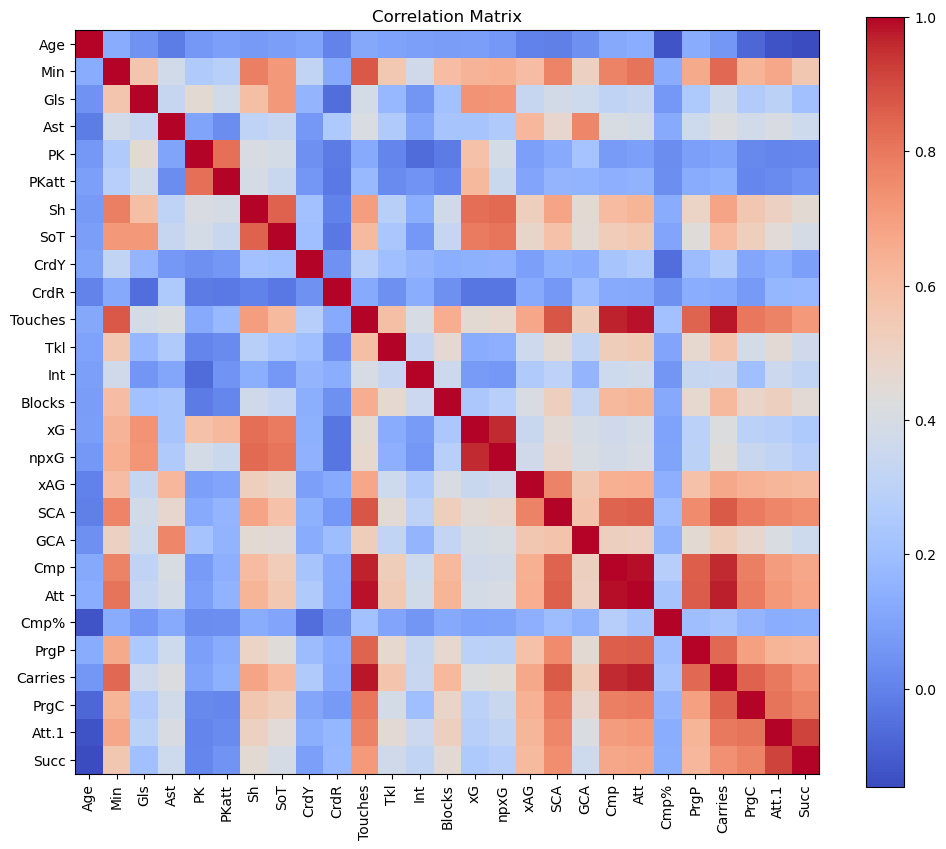

In [5]:
#PCA 

#Check for correlation
numeric_data = df.select_dtypes(include=[np.number]) #Numeric columns only
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

In [6]:
threshold = 0.7
high_corr_pairs = np.where(np.abs(corr_matrix) >= threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
                      for x, y in zip(*high_corr_pairs) if x != y]
high_corr_features = list(set([tuple(sorted(pair)) for pair in high_corr_features]))

len(high_corr_features)

50

27


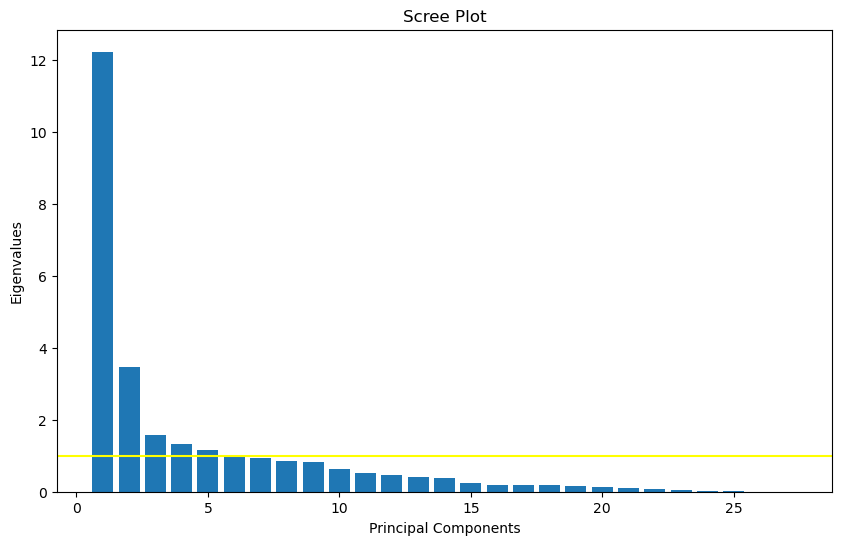

6

In [7]:
#PCA
pca = PCA()
pca.fit(numeric_data)
eigVals = pca.explained_variance_
num_predictors = len(eigVals)
print(num_predictors)
plt.figure(figsize=(10, 6))
plt.bar(np.linspace(1, num_predictors, num_predictors), eigVals)
plt.axhline(y=1, color='yellow', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()
components_to_keep = sum(eigVals > 1)
components_to_keep

In [8]:
pca_7 = PCA(n_components=7)
principal_components= pca_7.fit_transform(numeric_data)
loadings = pca_7.components_.T
loadings_df = pd.DataFrame(loadings, index=numeric_data.columns, columns=['PC{}'.format(i+1) for i in range(7)])
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Age,0.020330,0.054688,-0.413702,0.399476,-0.148734,-0.327769,-0.409853
Min,0.257896,0.059713,-0.147232,0.030038,-0.072268,0.052927,0.095729
Gls,0.155362,0.316871,0.056122,-0.007571,-0.189306,0.018106,0.119775
Ast,0.149534,-0.028614,0.452754,0.409595,-0.168211,-0.095720,-0.037131
PK,0.070376,0.386556,0.002362,0.136329,0.453234,0.078111,-0.139428
PKatt,0.077131,0.354432,-0.093024,0.119955,0.538897,0.113780,-0.129681
Sh,0.228335,0.230297,-0.017829,-0.127606,-0.104074,0.011572,0.023056
SoT,0.211554,0.259921,0.022477,-0.112851,-0.207845,-0.016529,0.022637
CrdY,0.073265,0.017575,-0.321615,0.203083,-0.262537,0.257244,0.395411
CrdR,0.036805,-0.099617,0.205862,0.459412,0.145543,0.330882,0.240699


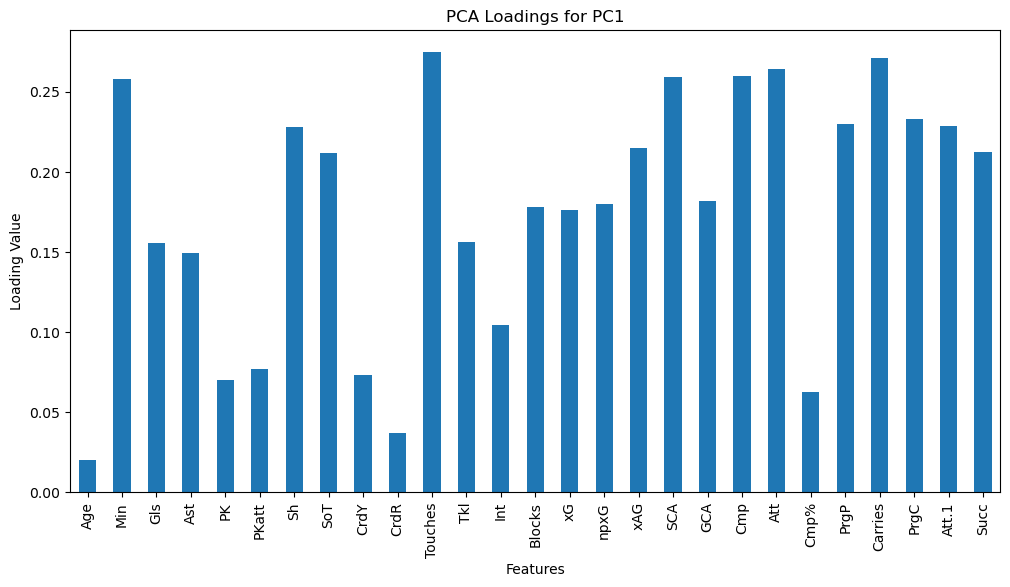

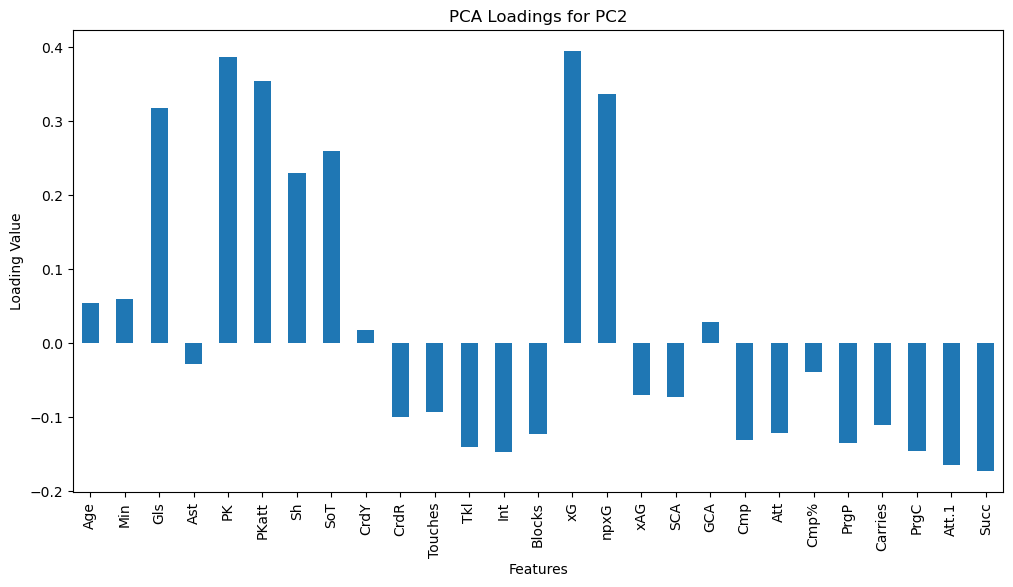

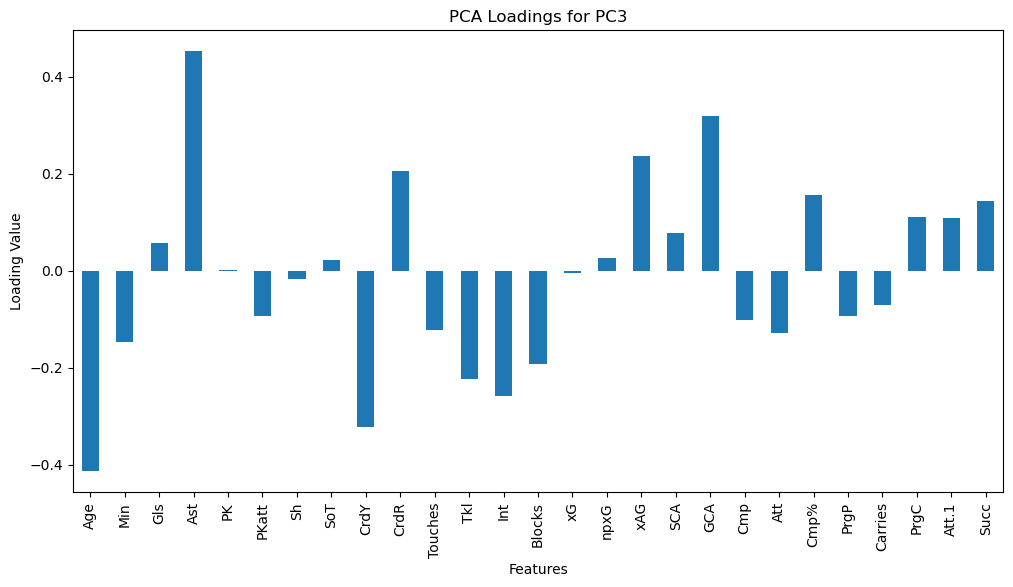

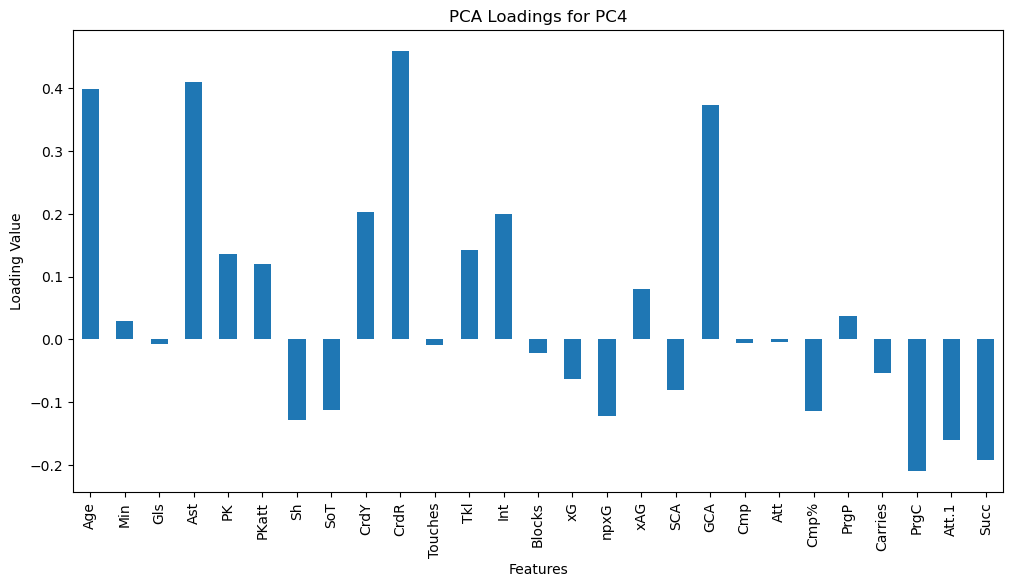

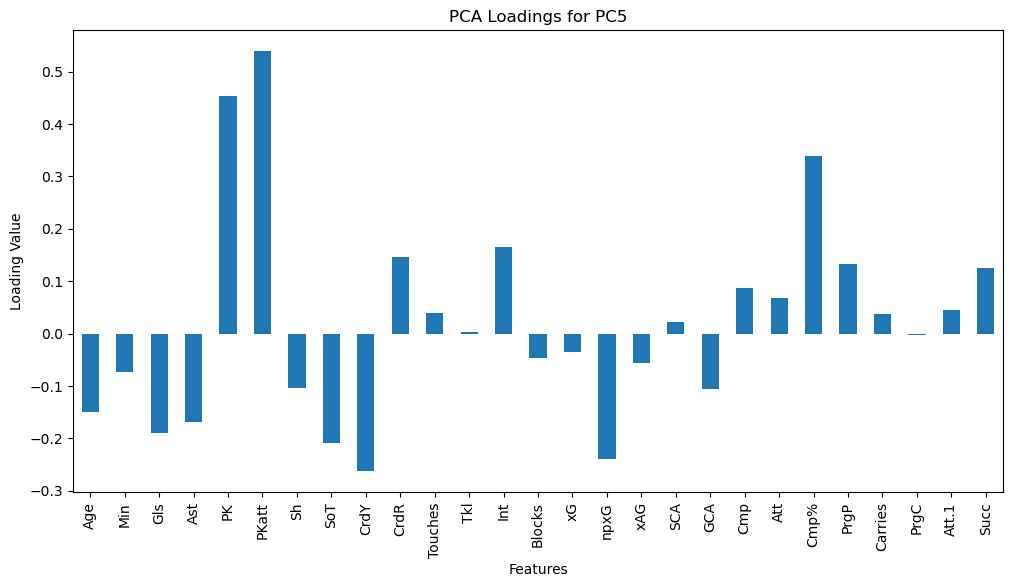

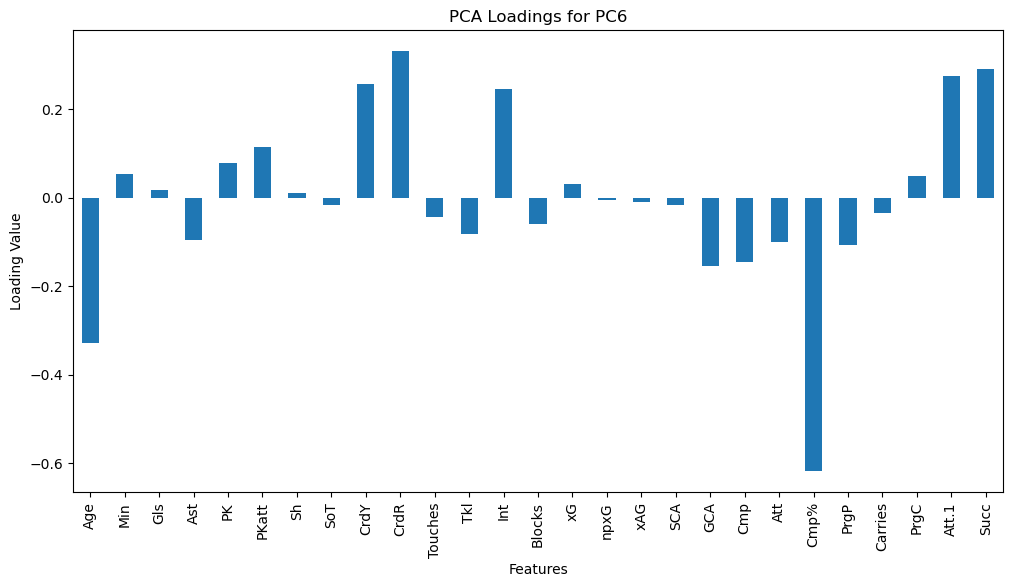

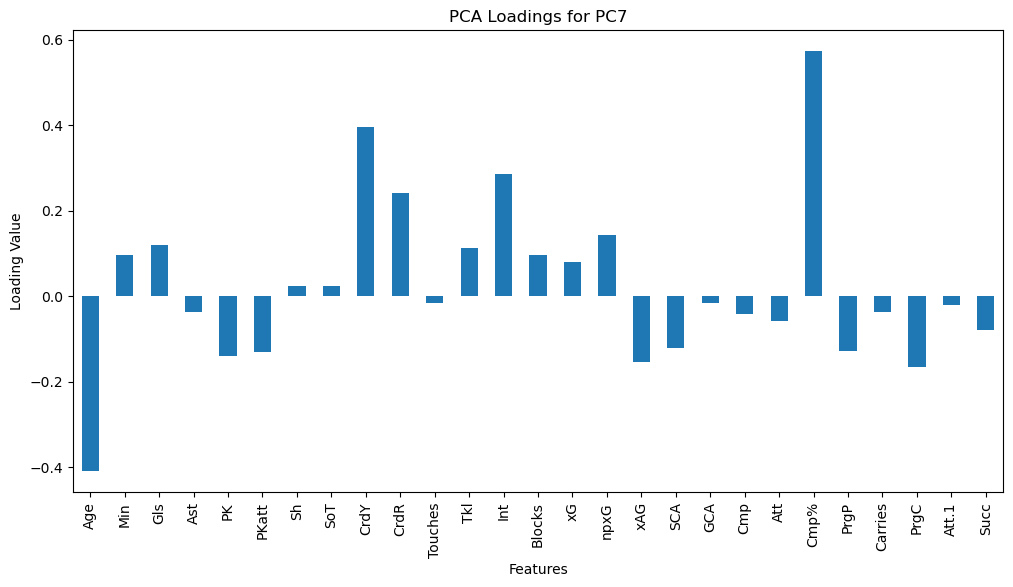

In [9]:
for i in range(7):  # Loop through each principal component
    plt.figure(figsize=(12, 6))
    loadings = loadings_df.iloc[:, i]
    loadings.plot(kind='bar')
    plt.title(f'PCA Loadings for PC{i+1}')
    plt.xlabel('Features')
    plt.ylabel('Loading Value')
    plt.show()

In [10]:
most_influential_features = {}

for i in range(loadings_df.shape[1]):
    pc = f'PC{i+1}'
    loadings = loadings_df[pc].abs().sort_values(ascending=False)
    most_influential_feature = loadings.idxmax()
    most_influential_features[pc] = (most_influential_feature, loadings[most_influential_feature])

most_influential_features

{'PC1': ('Touches', 0.2747379401263217),
 'PC2': ('xG', 0.39416980885936426),
 'PC3': ('Ast', 0.45275372140154513),
 'PC4': ('CrdR', 0.45941154494752345),
 'PC5': ('PKatt', 0.5388974109886523),
 'PC6': ('Cmp%', 0.6176459389358009),
 'PC7': ('Cmp%', 0.5731994713491203)}

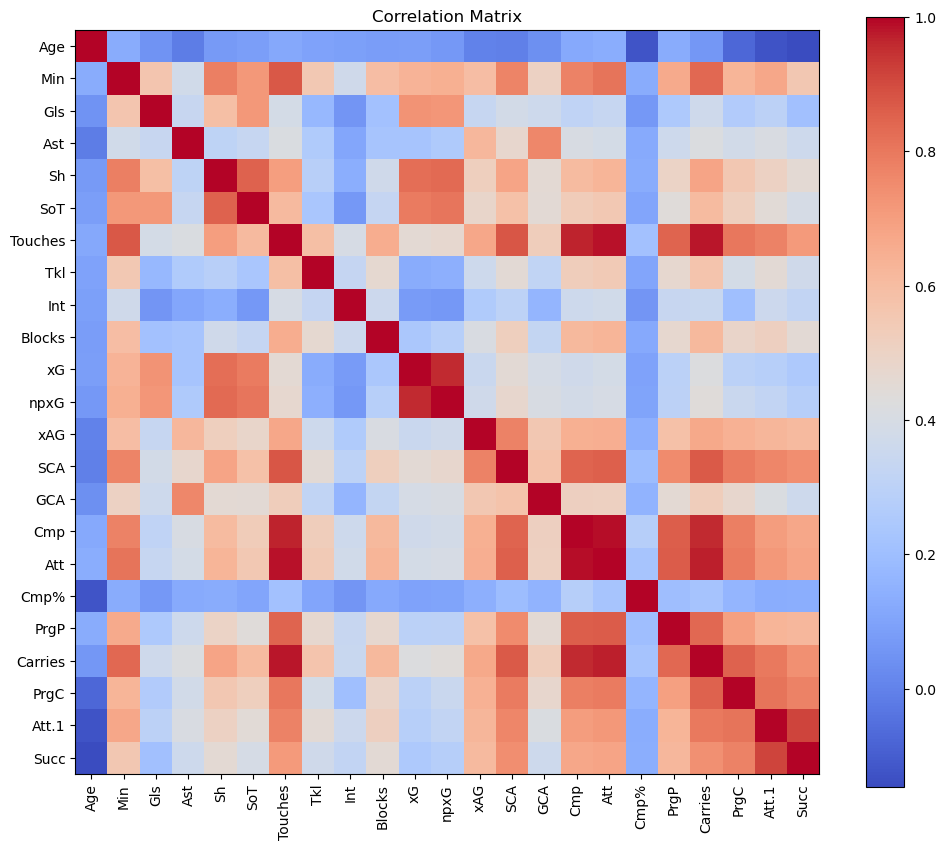

In [11]:
#The PCA Dont make sense, so we will redo this without Penalty Kicks penalty attempted and Yellow and Red Cards.
df_new = df.drop(columns=['PK','PKatt','CrdY','CrdR'])
numeric_data = df_new.select_dtypes(include=[np.number]) #Numeric columns only
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

In [12]:
threshold = 0.7
high_corr_pairs = np.where(np.abs(corr_matrix) >= threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
                      for x, y in zip(*high_corr_pairs) if x != y]

high_corr_features = list(set([tuple(sorted(pair)) for pair in high_corr_features]))

len(high_corr_features)

49

23


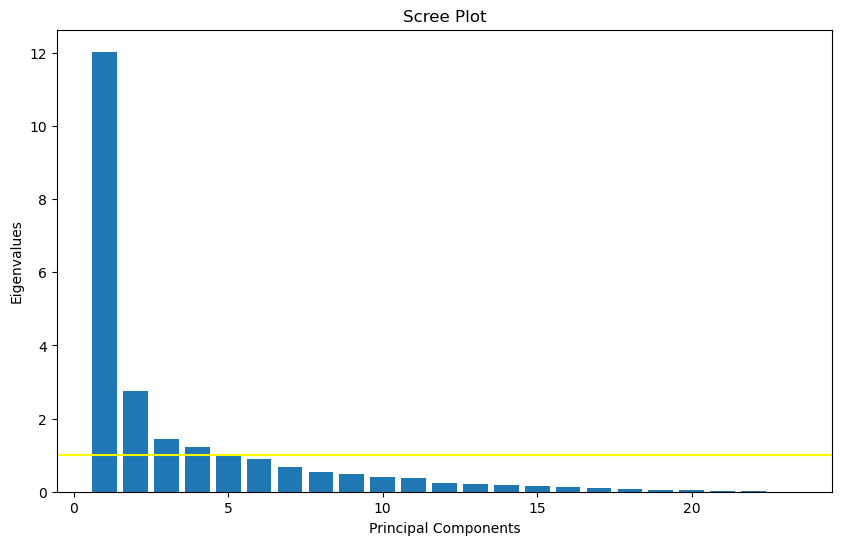

4

In [13]:
#PCA
pca = PCA()
pca.fit(numeric_data)
eigVals = pca.explained_variance_
num_predictors = len(eigVals)
print(num_predictors)
plt.figure(figsize=(10, 6))
plt.bar(np.linspace(1, num_predictors, num_predictors), eigVals)
plt.axhline(y=1, color='yellow', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()
components_to_keep = sum(eigVals > 1)
components_to_keep

In [14]:
pca_4 = PCA(n_components=4)
principal_components= pca_4.fit_transform(numeric_data)
loadings = pca_4.components_.T
loadings_df = pd.DataFrame(loadings, index=numeric_data.columns, columns=['PC{}'.format(i+1) for i in range(4)])
loadings_df

,PC1,PC2,PC3,PC4
Age,0.018932,0.053746,-0.508444,0.502417
Min,0.258369,0.086212,-0.170562,0.007376
Gls,0.152224,0.384540,0.022218,0.034638
Ast,0.151305,0.006284,0.469081,0.508203
Sh,0.226998,0.286145,-0.053728,-0.121487
SoT,0.210193,0.334987,-0.015026,-0.072062
Touches,0.277815,-0.097616,-0.122985,-0.014587
Tkl,0.159177,-0.168506,-0.208586,0.182213
Int,0.106021,-0.185404,-0.270995,0.104496
Blocks,0.181604,-0.123615,-0.217621,0.017895


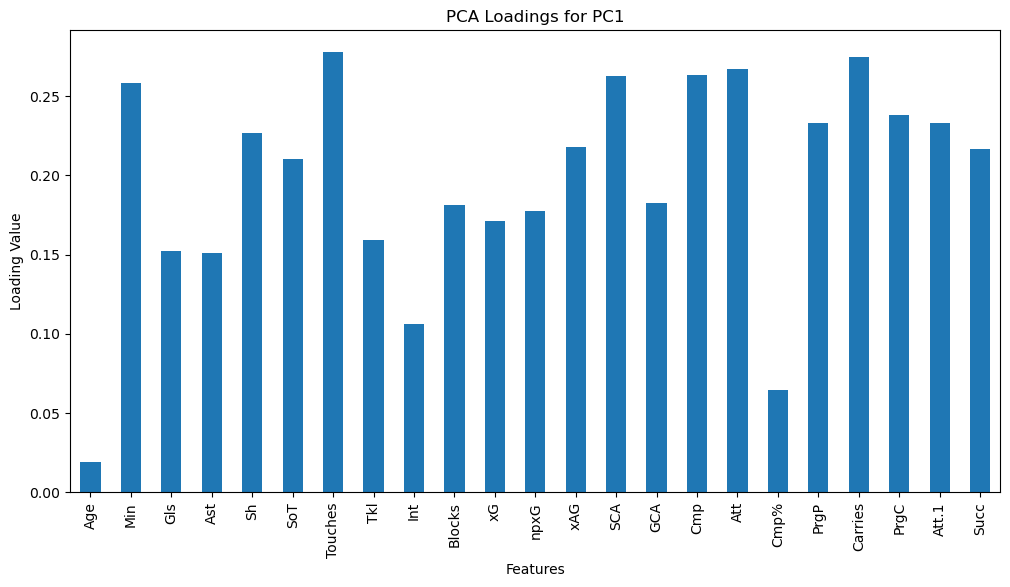

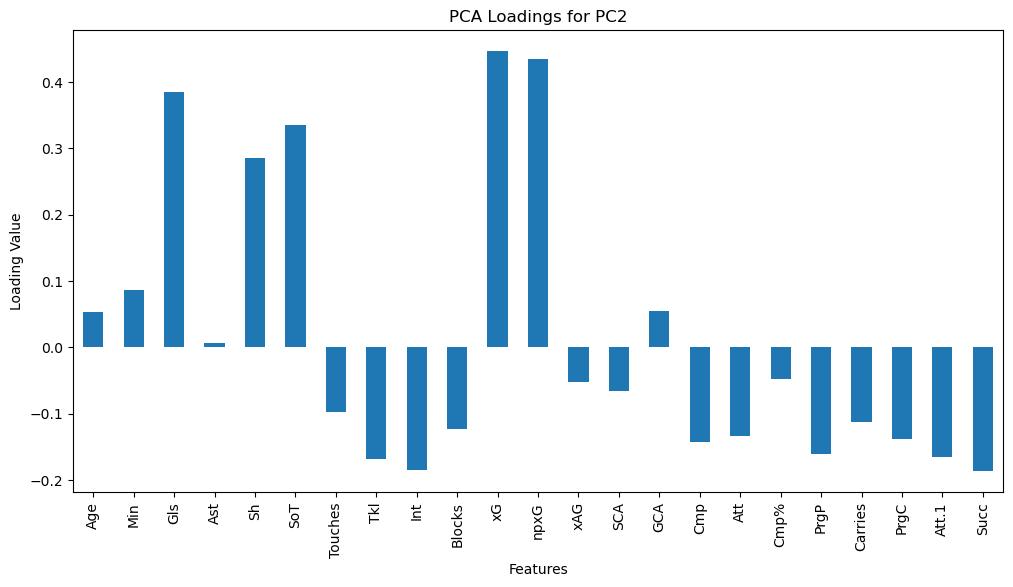

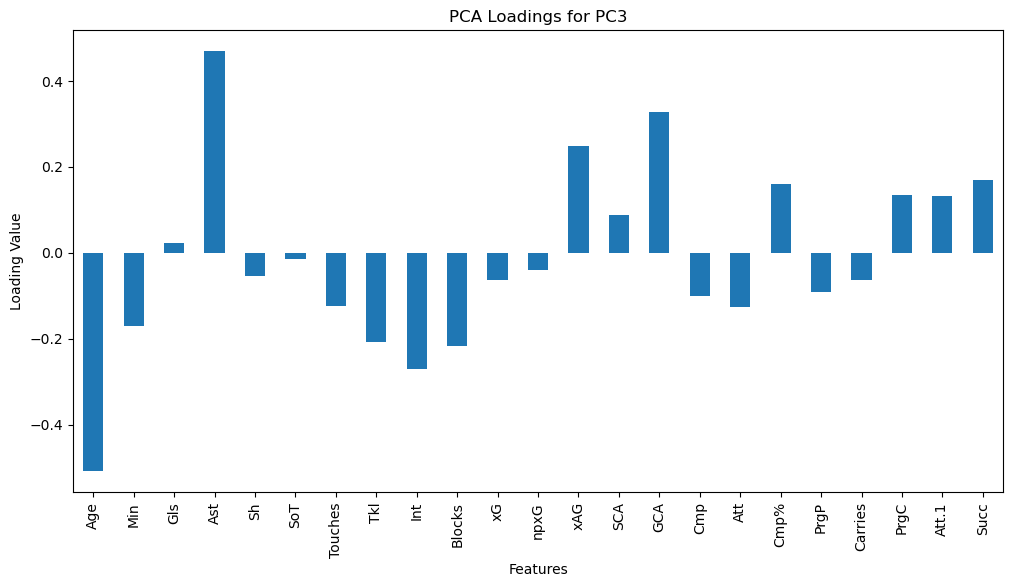

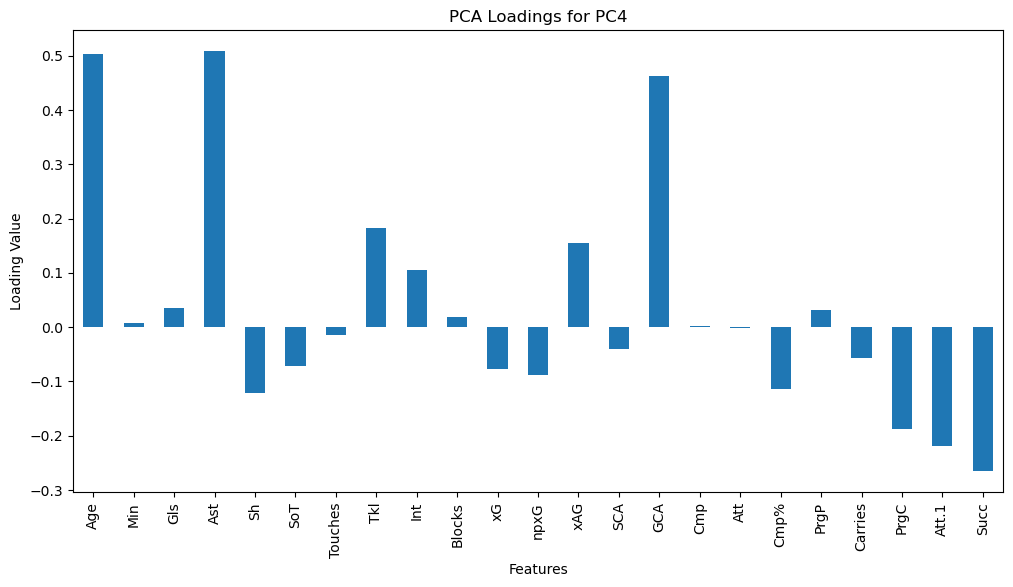

In [15]:
for i in range(4):  #Loop through each principal component
    plt.figure(figsize=(12, 6))
    loadings = loadings_df.iloc[:, i]
    loadings.plot(kind='bar')
    plt.title(f'PCA Loadings for PC{i+1}')
    plt.xlabel('Features')
    plt.ylabel('Loading Value')
    plt.show()

In [16]:
most_influential_features = {}

for i in range(loadings_df.shape[1]):
    pc = f'PC{i+1}'
    loadings = loadings_df[pc].abs().sort_values(ascending=False)
    most_influential_feature = loadings.idxmax()
    most_influential_features[pc] = (most_influential_feature, loadings[most_influential_feature])

most_influential_features

{'PC1': ('Touches', 0.2778147933589187),
 'PC2': ('xG', 0.44670146836089836),
 'PC3': ('Age', 0.5084443549966114),
 'PC4': ('Ast', 0.508202677201073)}

In [17]:
pca_scores_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
final_df = pd.concat([df[['Player', 'Team', 'Pos']].reset_index(drop=True), pca_scores_df], axis=1)
final_df
final_df.to_csv("forwardspca.csv", sep=';', encoding='utf-8', index=False)

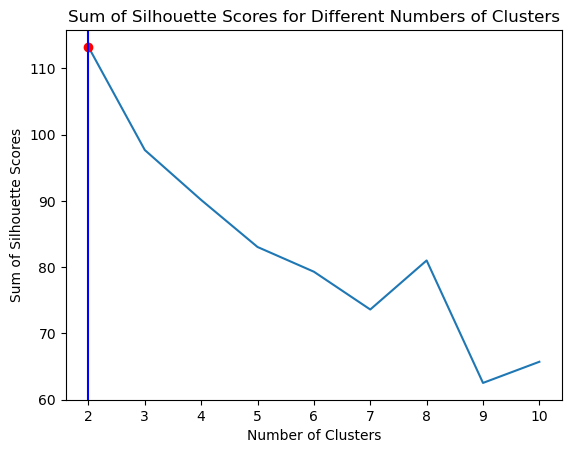

Optimal number of clusters: 2
Sum of silhouette scores: 113.2350947765305


In [18]:
X = final_df[['PC1', 'PC2', 'PC3', 'PC4']].values
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = np.sum(silhouette_samples(X, cluster_labels))
    silhouette_scores.append(silhouette_avg)

sum_silhouette_scores = sum(silhouette_scores)

max_silhouette_score_index = np.argmax(silhouette_scores) + 2 # Add 2 to account for starting with 2 clusters

plt.plot(range(2, 11), silhouette_scores)
plt.title('Sum of Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Silhouette Scores')
plt.plot(max_silhouette_score_index, silhouette_scores[max_silhouette_score_index - 2], 'ro') # Add a red dot on the optimal number of clusters
plt.axvline(x=max_silhouette_score_index, color='blue', linestyle='-')
plt.show()

print("Optimal number of clusters:", max_silhouette_score_index)
print("Sum of silhouette scores:", silhouette_scores[max_silhouette_score_index - 2])

In [19]:
kmeans = KMeans(n_clusters=max_silhouette_score_index, random_state=42)
clusters = kmeans.fit_predict(X)
final_df['Cluster'] = clusters
final_df.to_csv("forwardspca.csv", sep=';', encoding='utf-8', index=False)

In [20]:
#Now we gonna make a model to rank these players
#To get the weighted average we will use the variance explained by each pca feature

explained_variance_ratio = pca_4.explained_variance_ratio_
print(explained_variance_ratio)
sum(explained_variance_ratio)

#Since they dont add up to 100% we just gonna take the var/sum * 100 to make it weighted to 100
#0.0.52099459 /0.7555600045970268 * 100 = 67.99% 
# 15.83%, 8.24% , 6.96%
#Formula is 68.95pca1 + 15.83pca2 + 8.24pca3 + 6.96 pca4

[0.52099459 0.11963069 0.06228255 0.05265217]


0.7555600045970268

In [21]:
df_scores = final_df
weights = {'PC1': 68.95, 'PC2': 15.83, 'PC3': 8.24, 'PC4': 6.96}
df_scores['Composite Score'] = (
    df_scores['PC1'] * weights['PC1'] +
    df_scores['PC2'] * weights['PC2'] +
    df_scores['PC3'] * weights['PC3'] +
    df_scores['PC4'] * weights['PC4']
)
top_players_by_cluster = df_scores.groupby('Cluster').apply(
    lambda x: x.nlargest(10, 'Composite Score')
).reset_index(drop=True)

top_players_by_cluster.sort_values(by=['Cluster', 'Composite Score'], ascending=[True, False], inplace=True)

top_players_by_cluster[['Cluster', 'Player', 'Composite Score']]

cluster_0_df = df_scores[df_scores['Cluster'] == 0]
cluster_1_df = df_scores[df_scores['Cluster'] == 1]

cluster_0_sorted = cluster_0_df.sort_values(by='Composite Score', ascending=False)
cluster_1_sorted = cluster_1_df.sort_values(by='Composite Score', ascending=False)


cluster_0_sorted.to_csv("cluster0.csv", sep=';', encoding='utf-8', index=False)
cluster_1_sorted.to_csv("cluster1.csv", sep=';', encoding='utf-8', index=False)

top_players_by_cluster[['Cluster', 'Player', 'Composite Score']]


,Cluster,Player,Composite Score
0,0,Galeno,96.357561
1,0,Kyogo Furuhashi,81.941795
2,0,Mathys Tel,70.041215
3,0,Victor Osimhen,54.912615
4,0,Raphinha,53.479878
5,0,Giacomo Raspadori,40.635320
6,0,Youssef En-Nesyri,40.617290
7,0,Santiago Giménez,38.165892
8,0,Cedric Itten,33.181209
9,0,Simon Banza,24.954053


In [35]:
df_0 = pd.read_csv('cluster0.csv', delimiter=';')
df_1 = pd.read_csv('cluster1.csv', delimiter=';')
df_0[['Player', 'Cluster', 'Composite Score']].sort_values(by='Composite Score', ascending=False)[:10]


,Player,Cluster,Composite Score
0,Galeno,0,96.357561
1,Kyogo Furuhashi,0,81.941795
2,Mathys Tel,0,70.041215
3,Victor Osimhen,0,54.912615
4,Raphinha,0,53.479878
5,Giacomo Raspadori,0,40.635320
6,Youssef En-Nesyri,0,40.617290
7,Santiago Giménez,0,38.165892
8,Cedric Itten,0,33.181209
9,Simon Banza,0,24.954053


In [32]:
df_1[['Player', 'Cluster', 'Composite Score']].sort_values(by='Composite Score', ascending=False)[:10]

,Player,Cluster,Composite Score
0,Khvicha Kvaratskhelia,1,676.715119
1,Ousmane Dembélé,1,632.484530
2,Rodrygo,1,622.089004
3,Leroy Sané,1,606.080918
4,Harry Kane,1,577.811293
5,Bukayo Saka,1,555.518742
6,Vinicius Júnior,1,546.798135
7,Erling Haaland,1,516.624097
8,Mehdi Taremi,1,507.659762
9,Kylian Mbappé,1,473.041715


In [22]:
centroids = df_scores.groupby('Cluster')[['PC1', 'PC2', 'PC3', 'PC4']].mean()

centroids

,PC1,PC2,PC3,PC4
Cluster,,,,
0,-2.237737,-0.068886,0.073466,0.025328
1,4.038842,0.124331,-0.132597,-0.045713
